In [1]:
import torch

#define the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)

device= cuda


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [03:34<00:00, 11.5MB/s]

Extracting files...


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


#### 첫번째 시도

Using device: cuda
Epoch 1: Train Acc=0.8785, Val Acc=0.5625
Epoch 2: Train Acc=0.9467, Val Acc=0.5625
Epoch 3: Train Acc=0.9569, Val Acc=0.8750
Epoch 4: Train Acc=0.9548, Val Acc=0.6875
Epoch 5: Train Acc=0.9611, Val Acc=0.6875
Epoch 6: Train Acc=0.9678, Val Acc=0.6875
Epoch 7: Train Acc=0.9722, Val Acc=0.7500
Epoch 8: Train Acc=0.9745, Val Acc=0.6875
Epoch 9: Train Acc=0.9781, Val Acc=0.7500
Epoch 10: Train Acc=0.9804, Val Acc=0.8125
Epoch 11: Train Acc=0.9854, Val Acc=0.9375
Epoch 12: Train Acc=0.9856, Val Acc=0.8125
Epoch 13: Train Acc=0.9898, Val Acc=0.9375
Epoch 14: Train Acc=0.9885, Val Acc=0.8750
Epoch 15: Train Acc=0.9906, Val Acc=0.7500
Epoch 16: Train Acc=0.9935, Val Acc=0.8125
Epoch 17: Train Acc=0.9942, Val Acc=0.8125
Epoch 18: Train Acc=0.9994, Val Acc=0.8125
Epoch 19: Train Acc=0.9977, Val Acc=0.6875
Epoch 20: Train Acc=0.9987, Val Acc=0.8750

🎯 Test Accuracy: 0.7708

🧾 Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.98

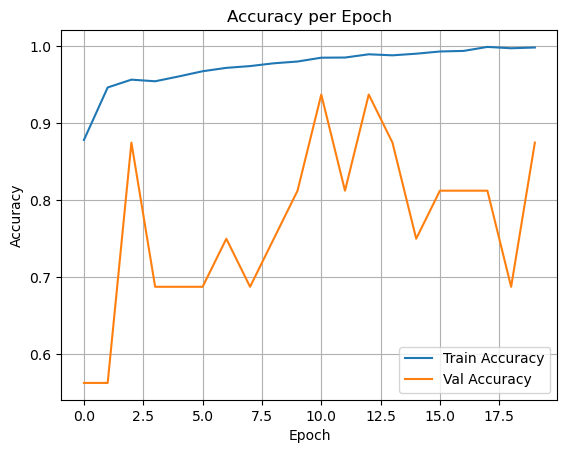

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ✅ 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ 데이터 경로 설정
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# ✅ 이미지 전처리
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ 수정된 LeNet 모델
class LeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # 🔧 Feature 크기 자동 계산
        self._to_linear = None
        self._get_conv_output()

        self.fc1 = nn.Linear(self._to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def _get_conv_output(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ✅ 학습 함수
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / len(loader), correct / total

# ✅ 평가 함수
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return running_loss / len(loader), correct / total, all_labels, all_preds

# ✅ 모델 정의 및 설정
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ 학습 루프
train_accs, val_accs = [], []
for epoch in range(20):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

# ✅ 테스트 평가
_, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# ✅ 그래프 출력
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### 두번째 시도

[Epoch 1] Train Acc: 0.8013 / Val Acc: 0.8860
[Epoch 2] Train Acc: 0.8803 / Val Acc: 0.8985
[Epoch 3] Train Acc: 0.9002 / Val Acc: 0.6695
[Epoch 4] Train Acc: 0.9058 / Val Acc: 0.9257
[Epoch 5] Train Acc: 0.9095 / Val Acc: 0.7312
[Epoch 6] Train Acc: 0.9137 / Val Acc: 0.8619
[Epoch 7] Train Acc: 0.9191 / Val Acc: 0.9048
[Epoch 8] Train Acc: 0.9198 / Val Acc: 0.9310
[Epoch 9] Train Acc: 0.9278 / Val Acc: 0.9404
[Epoch 10] Train Acc: 0.9310 / Val Acc: 0.8128
[Epoch 11] Train Acc: 0.9308 / Val Acc: 0.9425
[Epoch 12] Train Acc: 0.9362 / Val Acc: 0.9362
[Epoch 13] Train Acc: 0.9329 / Val Acc: 0.9393
[Epoch 14] Train Acc: 0.9441 / Val Acc: 0.9414
[Epoch 15] Train Acc: 0.9425 / Val Acc: 0.9404
[Epoch 16] Train Acc: 0.9408 / Val Acc: 0.9372
[Epoch 17] Train Acc: 0.9444 / Val Acc: 0.9404
[Epoch 18] Train Acc: 0.9415 / Val Acc: 0.9446
[Epoch 19] Train Acc: 0.9408 / Val Acc: 0.9435
[Epoch 20] Train Acc: 0.9465 / Val Acc: 0.9383
[Epoch 21] Train Acc: 0.9451 / Val Acc: 0.8975
[Epoch 22] Train Acc: 

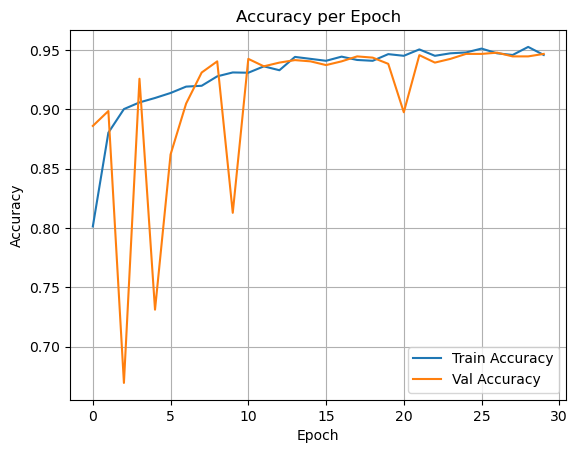

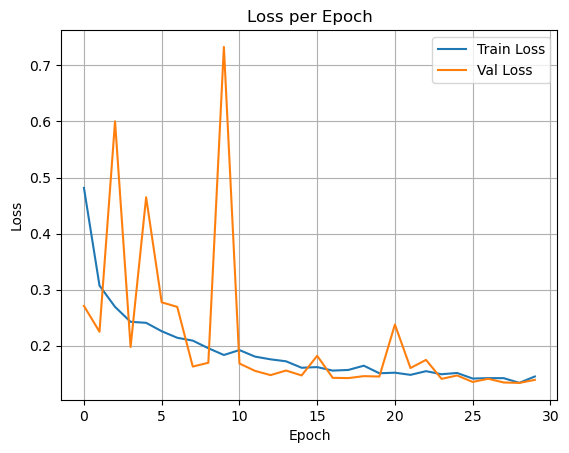

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "D:/시각지능특론/kagglehub_backup/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# ====== EarlyStopping 클래스 ======
class EarlyStopping:
    def __init__(self, patience=6):
        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# ====== DataLoader 설정 ======
transform_train = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

transform_valtest = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "train"), transform=transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "val"), transform=transform_valtest), batch_size=32)
test_loader = DataLoader(datasets.ImageFolder(os.path.join(base_dir, "test"), transform=transform_valtest), batch_size=32)

# ====== 개선된 LeNet 모델 정의 ======
class ImprovedLeNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self._to_linear = self._get_flatten_size()
        self.fc1 = nn.Linear(self._to_linear, 120)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(84, num_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 128, 128)
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# ====== 학습 및 평가 함수 ======
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item()
            preds = pred.argmax(1)
            correct += (preds == y).sum().item()
            y_true += y.cpu().tolist()
            y_pred += preds.cpu().tolist()
    return total_loss / len(loader), correct / len(loader.dataset), y_true, y_pred

# ====== 모델 학습 ======
model = ImprovedLeNet().to(device)
class_weights = torch.tensor([1.5, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
earlystop = EarlyStopping(patience=6)

train_accs, val_accs, train_losses, val_losses = [], [], [], []

for epoch in range(30):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} / Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)
    earlystop(val_loss, model)
    if earlystop.early_stop:
        print("⛔ Early stopping triggered.")
        model.load_state_dict(earlystop.best_model)
        break

# ====== 테스트 평가 ======
_, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion)
print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
print("\n🧾 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_loader.dataset.classes))

# ====== 그래프 출력 (show만) ======
plt.figure()
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


## ✅ 일반 LeNet 모델 성능 요약

| 항목 | 결과 |
|------|------|
| **Train Accuracy** | 약 95% (수렴 상태) |
| **Validation Accuracy** | 약 94.6% (안정적 수렴) |
| **Test Accuracy** | **83.8%** |
| **PNEUMONIA** (폐렴) Precision / Recall / F1 | **0.81 / 0.97 / 0.88** |
| **NORMAL** (정상) Precision / Recall / F1 | **0.93 / 0.61 / 0.74** |
| **Overall Macro F1** | 0.81 |
| **Overfitting 여부** | 없음 (Train/Val Loss 점진적 수렴) |

---

## 📊 해석 

- ✅ **PNEUMONIA Recall 0.97**: 폐렴 환자를 거의 놓치지 않고 잘 잡아냄 → **의료적 실효성 매우 높음**
- ⚠️ **NORMAL Recall 0.61**: 정상을 폐렴으로 잘못 판단한 경우 다소 존재 (False Positive 개선 필요)
- 📉 **Loss 그래프와 Accuracy 그래프 모두 수렴** → 안정적인 학습 완료
- 📌**전체적으로 일반 LeNet 기준으로 우수한 성능**이며, 추가적인 개선 여지는 존재
